# Testing tensorboard summaries

A short notebook for practicing using Tensorflow's summaries and Tensorboard.
 

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output

%matplotlib inline

I will build a simple linear regression problem, and see if I can keep track of the errors, the inferred slope and bias, and the hyperparameters (learning_rate, batch_size ...).

## Generating data

In [2]:
#Some random values for the true slope and bias. 
m_true = np.random.uniform(7)
b_true = np.random.uniform(5)

In [3]:
# A set of inputs 'x', and the true outputs, which have some noise. 

x = np.random.uniform(100, size= (1000,1))
noise = 10 * np.random.normal(size = x.shape)
y = m_true * x + b_true + noise

### Look at the generated data 

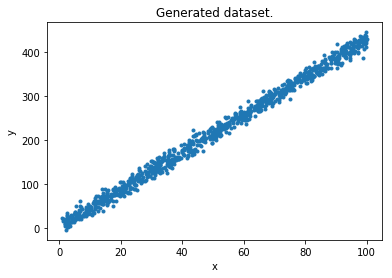

In [4]:
plt.plot(x.flatten() , y.flatten(), '.')
plt.title('Generated dataset.')
plt.xlabel('x');
plt.ylabel('y');

### Splitting into test and validation set

In [5]:
# Splitting into training and test set.

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

###  A function for taking random batches

In [6]:
def next_batch(X, labels, batch_size):
    """ A function for generating training batches. 
    X = Collection of examples.
    labels = True labels. 
    batch_size = Number of elements to be randomly selected. """
    
    sample_indices = np.random.choice(range(len(X)), size = batch_size, 
                                      replace = False)
    
    x_selected = X[sample_indices]
    y_selected = labels[sample_indices]
        
    return x_selected, y_selected

### Building the graph

In [7]:
tf.reset_default_graph()

In [8]:
# PLACEHOLDERS

# x-points, y-points and learning rate
points = tf.placeholder(tf.float32, [None, 1], name = 'x_points')
y_true = tf.placeholder(tf.float32, [None, 1], name = 'y_true')
lr = tf.placeholder(tf.float32, name = 'learning_rate')

# a text tensor to keep track of hyperparameters, and the summary node. 
with tf.variable_scope('parameter_logs'):
    parameter_log_ph = tf.placeholder(tf.string,[None,2], name='ph')
    parameter_log = tf.summary.text('summary_node', parameter_log_ph)


In [9]:
# Linear model: Generating slope and bias and computing the output. 

with tf.variable_scope('linear_model'):
    with tf.variable_scope('parameters'):
        m_var = tf.get_variable(name = 'slope', shape = (), initializer=tf.initializers.random_normal())
        b_var = tf.get_variable(name = 'bias', shape = (), initializer=tf.initializers.random_normal())
    
    with tf.variable_scope('output'):
        output = tf.add(tf.multiply(m_var, points), b_var)

# Summaries to track the evolution of slope and bias. 
slope_summ = tf.summary.scalar('slope_summary', m_var)
bias_summ = tf.summary.scalar('bias_summay', b_var)



Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# Loss function and optimizer.

with tf.variable_scope('loss_function'):
    mse = tf.losses.mean_squared_error(y_true, output)
    # Summary to keep logs on the loss function. 
    mse_summ = tf.summary.scalar('loss', mse)

with tf.variable_scope('training'):
    optimizer = tf.train.AdamOptimizer(learning_rate= lr)
    train = optimizer.minimize(mse)

Instructions for updating:
Use tf.cast instead.


In [11]:
# Initializer and saver, and SOME merged summaries (the hyperparameter summary is left out).
init = tf.global_variables_initializer()
#saver = tf.train.Saver()
merged_summs = tf.summary.merge([mse_summ, slope_summ, bias_summ])


In [12]:
counter = 0 # A counter to keep track of different models.

##  Training

Steps 3000
Train MSE:  53.863514 

Test MSE: 87.57358 



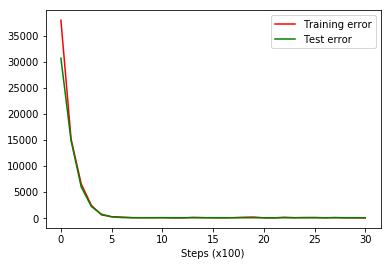

In [13]:
# Set some hyperparameters and save their values into an array. 
num_steps = 3000
batch_size = 10
learning_rate = 0.01

params_values = np.array([['steps', num_steps],
                         ['batch_size', batch_size], 
                         ['learning_rate', learning_rate ]])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

with tf.Session() as sess:
    
    sess.run(init)
    #saver.restore(sess, "./saved_models/tensorboard_linear_ex_" + str(counter) )
    
    
    train_writer = tf.summary.FileWriter('./tensorboard_logs/train/', sess.graph)
    test_writer = tf.summary.FileWriter('./tensorboard_logs/test/')
    
    train_losses = []
    test_losses = []
    
    # Saving parameter values.
    
    train_writer.add_summary(sess.run(parameter_log, feed_dict = {parameter_log_ph:params_values }))

    # Training
    for iteration in range(num_steps+1):
        
        x_batch, y_batch = next_batch(X_train, y_train, batch_size)
        
         
        _ , train_loss, train_summaries = sess.run([train, mse, merged_summs], 
                             feed_dict={points: x_batch, y_true: y_batch,
                                        lr:learning_rate})
        
        # Loggin MSE each 100 steps. 
        if iteration%100 == 0:
            
            test_loss, test_summaries  = sess.run([mse, mse_summ], 
                                              feed_dict={points:X_test, y_true:y_test})
            
            # Writting summaries.
            train_writer.add_summary(train_summaries, iteration)
            test_writer.add_summary(test_summaries, iteration)
            
            # Updating Python lists.
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            print('Steps {}'.format(iteration))
            print('Train MSE: ', train_losses[-1], '\n')
            print('Test MSE:',  test_losses[-1], '\n')
            clear_output(wait = True)
                   
                        
    # printing final results
    
    print('=======================================')
    print('Steps {}'.format(iteration))
    print('Train MSE: ', train_losses[-1], '\n')
    print('Test MSE:',  test_losses[-1], '\n')
    
    ax.cla()
    ax.plot(train_losses, 'r', label = 'Training error')
    ax.plot(test_losses, 'g', label = 'Test error')
    ax.set_xlabel('Steps (x100)')
    ax.legend()
                
    print('=======================================')
    #print('train_losses = ', train_losses, '\n')
    #print('test_losses = ', test_losses)
            
    
    train_writer.close()
    test_writer.close()
    
    m_model, b_model = sess.run([m_var,b_var]) # Python variables with inferred slope and bias. 
    
  #saver.restore(sess, "./saved_models/tensorboard_linear_ex_" + str(counter) )
  #counter +=1
    

By now, the summaries and the graph should be accesible through tensorboard. In order to see them run

tensorboard --logdir=./tensorboard_logs 

and acces the URL that appears in the command line. 

## Comparison with the original data.

Just for fun

In [14]:
print('Predicted slope: ', m_model)
print('True slope: ', m_true, '\n')
print('Predicted bias: ', b_model)
print('True bias: ', b_true)

Predicted slope:  4.253561
True slope:  4.238683007889732 

Predicted bias:  2.2669191
True bias:  3.6363224576689035


It appears that the bias could use some more training. This can also be seen in the tensorboard log, where it appears to not have converged yet. It is unnimportant for the goal of this notebook. 

In [15]:
# Using the inferred paramters to visualize the data. Full dataset.
preds = m_model * x + b_model

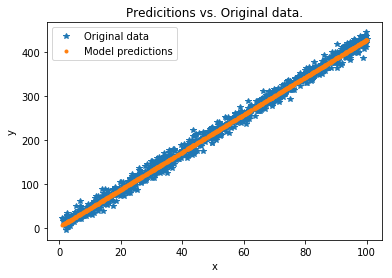

In [16]:
# Plot our predictions vs. the original points. 

plt.plot(x.flatten(), y.flatten(), '*', label = 'Original data')
plt.plot(x.flatten(), preds.flatten(), '.', label = 'Model predictions')
plt.title('Predicitions vs. Original data.')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

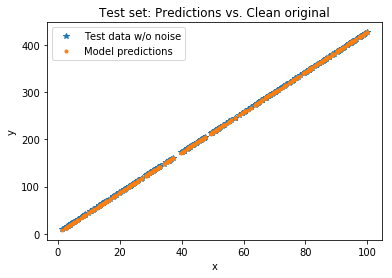

In [17]:
# Comparison on the test set, without the noise ('clean') on the original data.

clean_y_test = m_true * X_test + b_true
preds_test = m_model * X_test + b_model

plt.plot(X_test.flatten(), clean_y_test.flatten(), '*', label = 'Test data w/o noise')
plt.plot(X_test.flatten(), preds_test.flatten(), '.', label = 'Model predictions')
plt.title('Test set: Predictions vs. Clean original')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()